In [1]:
# import libraries
import pandas as pd
import yfinance as yf
import numpy as np
import math
from datetime import date, timedelta

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

today = date.today()

2023-11-23 23:15:42.101538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize the start and end dates of datasets. The end date is the current date and the start date is 2 years before the end date.

In [2]:
# set up date to download dataset (2 years)
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365*2)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

## Dowload datasets from Yahoo Finance
- End date: current day
- Lenght: 730
- Source: https://finance.yahoo.com/
- Crypto_names: BTC-USD, BNB-USD

Because the original data has an index of Date value, I need to create a Date column to store the Date value. Then reorder the columns for ease of EDA. Finally, I need to reset the index of the data.

In [3]:
# function to download dataset from yahoo
def download_data(crypto_name, start_date, end_date):
    # Dowload data form Yahoo Finance
    data = yf.download(crypto_name, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
    data["Date"] = data.index 
    data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

I use the download_data function above to download the BTC-USD dataset with initialized start and end dates.

In [4]:
# dowload btc-usd dataset
btc_data = download_data("BTC-USD", start_date, end_date)
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-23,56304.554688,57875.515625,55632.761719,57569.074219,57569.074219,37485803899
1,2021-11-24,57565.851562,57803.066406,55964.222656,56280.425781,56280.425781,36635566789
2,2021-11-25,57165.417969,59367.968750,57146.683594,57274.679688,57274.679688,34284016248
3,2021-11-26,58960.285156,59183.480469,53569.765625,53569.765625,53569.765625,41810748221
4,2021-11-27,53736.429688,55329.257812,53668.355469,54815.078125,54815.078125,30560857714


I use the download_data function above to download the BNB-USD dataset with initialized start and end dates.

In [5]:
# download bnb-usd dataset
bnb_data = download_data("BNB-USD", start_date, end_date)
bnb_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-23,559.570190,605.090454,559.041626,591.439575,591.439575,2927434189
1,2021-11-24,591.195557,594.830994,577.508362,581.395325,581.395325,2917418688
2,2021-11-25,590.356995,646.958801,587.859802,603.730225,603.730225,2537227998
3,2021-11-26,639.003601,657.512939,566.533142,585.147339,585.147339,4254504824
4,2021-11-27,587.103333,621.386658,584.794312,600.336792,600.336792,2485529516


Explore BTC-USD information about columns, non-null values and data types.

In [6]:
# explore BTC information
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       730 non-null    datetime64[ns]
 1   Open       730 non-null    float64       
 2   High       730 non-null    float64       
 3   Low        730 non-null    float64       
 4   Close      730 non-null    float64       
 5   Adj Close  730 non-null    float64       
 6   Volume     730 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 40.1 KB


Explore mean, min, IQR, Max, standard of the BTC-USD columns.

In [7]:
# Explore BTC count-mean-min-IQR-max-std
btc_data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,730,730.000000,730.000000,730.000000,730.000000,730.000000,7.300000e+02
mean,2022-11-22 12:00:00,29052.073213,29583.162013,28473.608155,29020.153160,29020.153160,2.464414e+10
min,2021-11-23 00:00:00,15782.300781,16253.047852,15599.046875,15787.284180,15787.284180,5.331173e+09
25%,2022-05-24 06:00:00,21527.707031,21803.264648,20957.500488,21529.596191,21529.596191,1.564357e+10
50%,2022-11-22 12:00:00,27266.462891,27773.986328,26830.585938,27272.520508,27272.520508,2.357145e+10
75%,2023-05-23 18:00:00,35079.457031,35801.295898,34444.807617,35073.985352,35073.985352,3.098888e+10
max,2023-11-22 00:00:00,58960.285156,59367.968750,57146.683594,57806.566406,57806.566406,1.189925e+11
std,NaN,9393.250428,9603.830623,9110.105846,9327.552741,9327.552741,1.237223e+10


Explore BNB-USD information about columns, non-null values and data types

In [8]:
# explore BNB information
bnb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       730 non-null    datetime64[ns]
 1   Open       730 non-null    float64       
 2   High       730 non-null    float64       
 3   Low        730 non-null    float64       
 4   Close      730 non-null    float64       
 5   Adj Close  730 non-null    float64       
 6   Volume     730 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 40.1 KB


Explore mean, min, IQR, Max, standard of the BNB-USD columns

In [9]:
# Explore BNB count-mean-min-IQR-max-std
bnb_data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,730,730.000000,730.000000,730.000000,730.000000,730.000000,7.300000e+02
mean,2022-11-22 12:00:00,312.499459,318.937510,305.211360,311.963534,311.963534,1.091767e+09
min,2021-11-23 00:00:00,196.955795,206.659103,184.540054,197.042999,197.042999,2.038465e+08
25%,2022-05-24 06:00:00,244.801617,248.273106,241.252182,244.662987,244.662987,4.831652e+08
50%,2022-11-22 12:00:00,295.273758,301.748383,287.220520,295.007034,295.007034,8.555792e+08
75%,2023-05-23 18:00:00,332.824280,339.697327,327.462914,332.200279,332.200279,1.471460e+09
max,2023-11-22 00:00:00,639.003601,657.512939,619.197205,627.971558,627.971558,5.390604e+09
std,NaN,88.661292,91.352563,85.049897,87.953820,87.953820,8.080539e+08


Check and count null values in each dataset.

In [10]:
# check null values
print("BTC:")
print("Has Null values?:",btc_data.isnull().values.any())
print("Shape:", btc_data.shape)

print("\nBNB:")
print("Has Null values?:",bnb_data.isnull().values.any())
print("Shape:", bnb_data.shape)

BTC:
Has Null values?: False
Shape: (730, 7)

BNB:
Has Null values?: False
Shape: (730, 7)


Because datasets are downloaded directly at finance yahoo and are tracked every second, there are no null values.

## EDA - Exploratory Data Analyst

Functions to drawing *Monthly comparision between Stock open and close price*, *Monthly High and Low stock price* and *Stock analysis Chart*

In [11]:
# plot functions
def plot(y):
    names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

    fig = px.line(y, x=y.Date, y=[y['Open'], y['Close'], y['High'], y['Low']],labels={'Date': 'Date','value':'Stock value'})
    fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
    fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)

    fig.show()
    return fig

def high_low_plot(df, y, new_order):
    monthvise_high = y.groupby(df['Date'].dt.strftime('%B'))['High'].max()
    monthvise_high = monthvise_high.reindex(new_order, axis=0)

    monthvise_low = y.groupby(df['Date'].dt.strftime('%B'))['Low'].min()
    monthvise_low = monthvise_low.reindex(new_order, axis=0)

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=monthvise_high.index,
        y=monthvise_high,
        name='Stock high Price',
        marker_color='rgb(0, 153, 204)'
    ))
    fig.add_trace(go.Bar(
        x=monthvise_low.index,
        y=monthvise_low,
        name='Stock low Price',
        marker_color='rgb(255, 128, 0)'
    ))

    fig.update_layout(barmode='group', title=' Monthly High and Low stock price')
    fig.show()
    return fig

def open_close_plot(data):
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=data.index,
        y=data['Open'],
        name='Stock Open Price',
        marker_color='crimson'
    ))
    fig.add_trace(go.Bar(
        x=data.index,
        y=data['Close'],
        name='Stock Close Price',
        marker_color='lightsalmon'
    ))

    fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Monthly comparision between Stock open and close price')
    fig.show()
    return fig

Function to explore dataset of each year.

In [12]:
# Explore data yearly
def data_yearly(df, start_year, end_year):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    y = df.loc[(df['Date'] >= f'{str(start_year)}-01-01')
                     & (df['Date'] < f'{str(end_year)}-01-01')]

    y.drop(y[['Adj Close','Volume']],axis=1)

    monthvise= y.groupby(y['Date'].dt.strftime('%B'))[['Open','Close']].mean()
    new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    monthvise = monthvise.reindex(new_order, axis=0)
    print(monthvise)

    open_close_plot(monthvise)
    high_low_plot(df, y, new_order)
    plot(y)

    #return monthvise

### BTC-USD

Explore start date and end date of the dataset.

In [13]:
# start date and end date of the dataset 
start_date=btc_data.iloc[0][0]
end_date=btc_data.iloc[-1][0]


print('Starting Date',start_date)
print('Ending Date',end_date)

Starting Date 2021-11-23 00:00:00
Ending Date 2023-11-22 00:00:00


#### In 2021

In [14]:
# BTC
data_yearly(btc_data, 2021, 2022)

                   Open         Close
Date                                 
January             NaN           NaN
February            NaN           NaN
March               NaN           NaN
April               NaN           NaN
May                 NaN           NaN
June                NaN           NaN
July                NaN           NaN
August              NaN           NaN
September           NaN           NaN
October             NaN           NaN
November   56708.447754  56446.184082
December   49670.411794  49263.209173


In 2021, I only took BTC data for November-December. During this time, the value of BTC dropped sharply, and the close price reached its lowest on December 17 with a value of 46.2k.

#### In 2022

In [15]:
# BTC
data_yearly(btc_data, 2022, 2023)

                   Open         Close
Date                                 
January    41368.073463  41114.422379
February   40591.103934  40763.474051
March      41889.148438  41966.237525
April      41694.653646  41435.319661
May        31900.711127  31706.105217
June       24783.338477  24383.685482
July       21424.733052  21539.253843
August     22471.866557  22366.266318
September  19821.353711  19804.779232
October    19616.090285  19650.525643
November   17711.480599  17600.814323
December   16969.578818  16949.608808


In 2022, BTC maintained its year-long downward trend. Although there was an increase in fluctuation around March with the close price reaching a peak value of 47.44k. But after that, the currency continued to fall sharply, reaching 15.88k in early November and fluctuating slightly until the end of the year.

#### In 2023

In [16]:
# BTC
data_yearly(btc_data, 2023, 2024)

                   Open         Close
Date                                 
January    20043.860131  20250.717490
February   23304.086007  23304.539202
March      24945.340411  25116.900895
April      28823.841732  28857.574544
May        27562.723160  27499.307145
June       27651.926758  27763.198437
July       30098.767578  30057.469947
August     27959.756615  27852.792843
September  26271.268229  26306.136393
October    29511.811114  29755.895161
November   36096.618253  36224.665305
December            NaN           NaN


From the beginning of 2023 until now, the increasing trend is clearly shown compared to last year. BTC has increased sharply to date with a peak of 37.31k in mid-November and tends to continue to increase until the end of the year.

### BNB-USD

Explore start date and end date of the dataset.

In [17]:
# start date and end date of the dataset 
start_date=bnb_data.iloc[0][0]
end_date=bnb_data.iloc[-1][0]


print('Starting Date',start_date)
print('Ending Date',end_date)

Starting Date 2021-11-23 00:00:00
Ending Date 2023-11-22 00:00:00


#### In 2021

In [18]:
# BNB
data_yearly(bnb_data, 2021, 2022)

                 Open      Close
Date                            
January           NaN        NaN
February          NaN        NaN
March             NaN        NaN
April             NaN        NaN
May               NaN        NaN
June              NaN        NaN
July              NaN        NaN
August            NaN        NaN
September         NaN        NaN
October           NaN        NaN
November   600.494461  602.54950
December   556.038056  551.83804


In 2021, I have data for the last 40 days of the year. During these 40 days, BNB fluctuated sharply until the end of the year and the close price reached its lowest point in mid-December with a value of 511.22k.

#### In 2022

In [19]:
# BNB
data_yearly(bnb_data, 2022, 2023)

                 Open       Close
Date                             
January    446.455420  442.029668
February   393.852540  394.614115
March      396.261171  397.352503
April      417.316946  415.605955
May        326.631463  324.777569
June       253.123441  249.748236
July       246.791995  248.866326
August     302.907766  302.763520
September  277.855970  278.032468
October    280.898194  282.266879
November   298.695680  297.861898
December   265.371770  263.616611


In 2022, BNB decreased sharply and the close price reached the smallest value of 197.04k. After that, fluctuations increased slightly until the end of the year.

#### In 2023

In [20]:
# BNB
data_yearly(bnb_data, 2023, 2024)

                 Open       Close
Date                             
January    285.929391  288.004860
February   313.786586  313.408470
March      308.748325  309.237018
April      323.645232  324.307049
May        314.534315  313.544577
June       255.371225  253.156196
July       242.476818  242.500122
August     230.508589  229.714023
September  213.420660  213.360542
October    215.122406  215.475766
November   242.951512  243.389517
December          NaN         NaN


In the first half of 2023, BNB increased sharply in the first half of the year and the close price peaked at 343.19k. However, in the second half of the year, BNB dropped sharply with the smallest value reaching 206.03k.

## Predicted Model
- Model: Long Short-Term Memory (LSTM)
- Lenght training data: 730
- Output: Predicting Close Price

In [21]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        #print(dataX)
        dataY.append(dataset[i + time_step, 0])
        #print(dataY)
    return np.array(dataX), np.array(dataY)

In [22]:
def pre_processing(data):
    close_df = data[["Date", "Close"]]
    print("Shape of close dataframe:", close_df.shape)
    
    fig = px.line(close_df, x= close_df.Date, y= close_df.Close, labels={'date':'Date','close':'Close Stock'})
    fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='pink')
    fig.update_layout(title_text='Whole period of price 2021-2023', plot_bgcolor='white', 
                    font_size=15, font_color='black')
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

    close_df = close_df[close_df['Date'] > '2021-11-20']
    close_stock = close_df.copy()
    print("Total data for prediction: ",close_df.shape[0])

    fig = px.line(close_df, x=close_df.Date, y=close_df.Close,labels={'date':'Date','close':'Close Stock'})
    fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
    fig.update_layout(title_text='Considered period to predict Bitcoin close price', 
                    plot_bgcolor='white', font_size=15, font_color='black')
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

    # deleting date column and normalizing using MinMax Scaler
    del close_df['Date']
    scaler=MinMaxScaler(feature_range=(0,1))
    close_df=scaler.fit_transform(np.array(close_df).reshape(-1,1))
    print("Dataset:", close_df.shape)

    # the training set as 80% and 20% testing set
    training_size=int(len(close_df)*0.80)
    test_size=len(close_df)-training_size
    train_data,test_data=close_df[0:training_size,:],close_df[training_size:len(close_df),:1]
    print("train_data: ", train_data.shape)
    print("test_data: ", test_data.shape)
    

    return close_stock, close_df, train_data, test_data, scaler

### BTC-USD

#### Pre-processing

Exploring whole preriod of time-frame in 2021-2023 and in 2023

In [23]:
close_stock, close_df, train_data, test_data, scaler = pre_processing(btc_data)
close_stock.to_csv("btc_training_data.csv")

Shape of close dataframe: (730, 2)


Total data for prediction:  730


Dataset: (730, 1)
train_data:  (584, 1)
test_data:  (146, 1)


Now, I set the time_step parameter representing the number of previous time steps that will be used to predict the current time step. Then use create_dataset function above to divide train_data and test_data into X_train, y_train, X_test, y_test based on time_step. Finally, I need to reshape X_train and X_test to ensure they are in the correct format [samples, time steps, features] while using the LSTM model.

In [24]:
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (582, 1)
y_train:  (582,)
X_test:  (144, 1)
y_test (144,)
X_train:  (582, 1, 1)
X_test:  (144, 1, 1)


#### Train model

In [25]:
model=Sequential()
model.add(LSTM(10,input_shape=(None,1),activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=80,batch_size=1,verbose=1)

Epoch 1/80
582/582 [==============================] - 2s 2ms/step - loss: 0.0403 - val_loss: 0.0019
Epoch 2/80
582/582 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 3.6272e-04
Epoch 3/80
582/582 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 5.0850e-04
Epoch 4/80
582/582 [==============================] - 1s 1ms/step - loss: 7.9719e-04 - val_loss: 2.7792e-04
Epoch 5/80
582/582 [==============================] - 1s 1ms/step - loss: 7.8657e-04 - val_loss: 4.7421e-04
Epoch 6/80
582/582 [==============================] - 1s 1ms/step - loss: 7.6843e-04 - val_loss: 4.4378e-04
Epoch 7/80
582/582 [==============================] - 1s 1ms/step - loss: 7.3293e-04 - val_loss: 2.3750e-04
Epoch 8/80
582/582 [==============================] - 1s 1ms/step - loss: 7.2353e-04 - val_loss: 2.6459e-04
Epoch 9/80
582/582 [==============================] - 1s 1ms/step - loss: 6.8461e-04 - val_loss: 2.0697e-04
Epoch 10/80
582/582 [=======================

#### Evaluate Model

Exploring Training and Validation loss plot

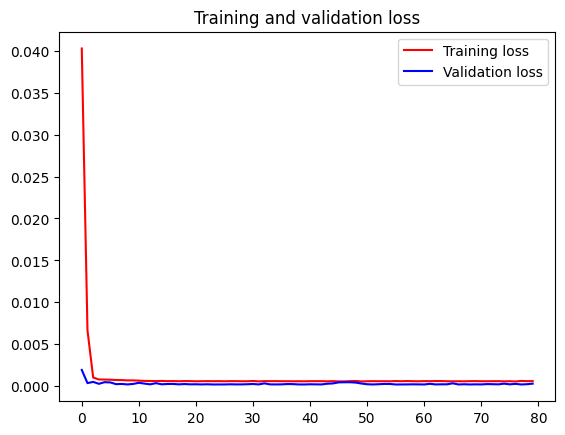

<Figure size 640x480 with 0 Axes>

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

The plot shows that the model is good with training loss and validation loss decreasing as the number of epochs increases and the model is not overfitting because the number of epochs is just enough so that the model does not learn more.

Now, let's explore whether the evaluation metrics are really as good as the model shows.

In [27]:
# the prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

5/5 [==============================] - 0s 1ms/step


((582, 1), (144, 1))

Before calculating the metrics, I need to transform back the scaled parameters to the original form.

In [28]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [29]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9910235426003731
Test data explained variance regression score: 0.9702749790304719


- Train data explained variance regression score: 0.9678:

A score close to 1 indicates that your model is very good at explaining the variance in the training data set (about 96.78%). This is a positive result and shows that the model learned important variations in the training data.
- Test data explained variance regression score: 0.9587:

Similar to the above, a score close to 1 for the test set (about 95.87%) is also a positive result. It represents the model's ability to explain the variance in the test data

In [30]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.98999838344957
Test data R2 score: 0.9558129426231757


- Train data R2 score: 0.9678:

R2 score close to 1 for the training data set (about 96.78%) is a positive result. It indicates that your model explains a large portion of the variation in the training data.
- Test data R2 score: 0.9557:

For the test set, the R2 score is also quite high (about 95.57%), implying that the model explains a large portion of the variation in the test data.

In [31]:
# predictions plot
look_back=time_step
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (730, 1)
Test predicted data:  (730, 1)


Looking at the graph above, the results of the train predicted and test predicted are quite close to the original value. This ensures again a well-functioning model.

Next, I will predict the close price within the next 30 days. First, I need to prepare the input data (x_input) then convert it to a list so that it can be easily expanded and updated. Then I use a loop to predict the next 30 days, if temp_input has enough data then the model predicts the next value on temp_input and expands lst_out. In contrast, the model uses the current temp_input to predict the outcome.

In [32]:
# Prepare input dataset
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


Next, I will convert the lst_output prediction result into a list and combine it with the normalized close Price (close_df). Use scaler.inverse_transform to convert the normalized value to the original value. Finally, plot the predicted and actual values of the Close price.

In [33]:
lstmdf=close_df.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Days'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


Finally, save model

In [34]:
model.save("btc_lstm.h5")

### BNB-USD

Exploring whole preriod of time-frame in 2021-2023 and in 2023

In [35]:
close_stock, close_df, train_data, test_data, scaler = pre_processing(bnb_data)
close_stock.to_csv("bnb_training_data.csv")

Shape of close dataframe: (730, 2)


Total data for prediction:  730


Dataset: (730, 1)
train_data:  (584, 1)
test_data:  (146, 1)


Now, I set the time_step parameter representing the number of previous time steps that will be used to predict the current time step. Then use create_dataset function above to divide train_data and test_data into X_train, y_train, X_test, y_test based on time_step. Finally, I need to reshape X_train and X_test to ensure they are in the correct format [samples, time steps, features] while using the LSTM model.

In [36]:
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (582, 1)
y_train:  (582,)
X_test:  (144, 1)
y_test (144,)
X_train:  (582, 1, 1)
X_test:  (144, 1, 1)


#### Train model

In [37]:
model=Sequential()
model.add(LSTM(10,input_shape=(None,1),activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=70,batch_size=1,verbose=1)

Epoch 1/70
582/582 [==============================] - 2s 2ms/step - loss: 0.0475 - val_loss: 0.0492
Epoch 2/70
582/582 [==============================] - 1s 1ms/step - loss: 0.0218 - val_loss: 0.0310
Epoch 3/70
582/582 [==============================] - 1s 1ms/step - loss: 0.0130 - val_loss: 0.0188
Epoch 4/70
582/582 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 5/70
582/582 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/70
582/582 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 7/70
582/582 [==============================] - 1s 1ms/step - loss: 9.7645e-04 - val_loss: 0.0016
Epoch 8/70
582/582 [==============================] - 1s 1ms/step - loss: 9.7311e-04 - val_loss: 0.0010
Epoch 9/70
582/582 [==============================] - 1s 1ms/step - loss: 9.8156e-04 - val_loss: 0.0017
Epoch 10/70
582/582 [==============================] - 1s 1ms/step - loss: 9.8040e-04 - 

#### Evaluate Model

Exploring Training and Validation loss plot

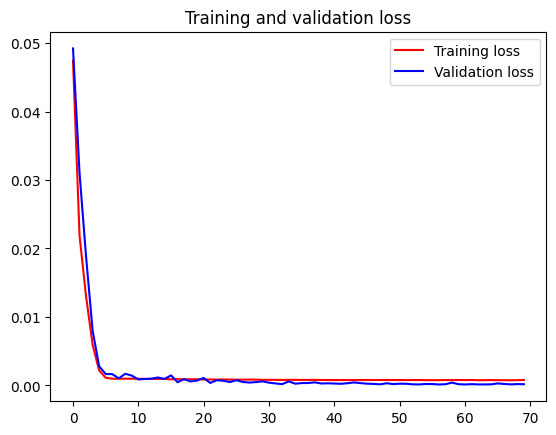

<Figure size 640x480 with 0 Axes>

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

The plot shows that the model is good with training loss and validation loss decreasing as the number of epochs increases and the model is not overfitting because the number of epochs is just enough so that the model does not learn more.

Now, let's explore whether the evaluation metrics are really as good as the model shows.

In [39]:
# the prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

5/5 [==============================] - 0s 1ms/step


((582, 1), (144, 1))

Before calculating the metrics, I need to transform back the scaled parameters to the original form.

In [40]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [41]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9814877516830964
Test data explained variance regression score: 0.9062269387169161


- Train data explained variance regression score: 0.9530:

A score close to 1 indicates that your model is very good at explaining the variance in the training data set (about 95.30%). This is a positive result and shows that the model learned important variations in the training data.
- Test data explained variance regression score: 0.9006:

Similar to the above, a score close to 1 for the test set (about 90.06%) is also a positive result. It represents the model's ability to explain the variance in the test data

In [42]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9814848236580628
Test data R2 score: 0.8569119302164199


- Train data R2 score: 0.9528:

R2 score close to 1 for the training data set (about 95.28%) is a positive result. It indicates that your model explains a large portion of the variation in the training data.
- Test data R2 score: 0.8866:

For the test set, the R2 score is also quite high (about 88.66%), implying that the model explains a large portion of the variation in the test data.

In [43]:
# predictions plot
look_back=time_step
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (730, 1)
Test predicted data:  (730, 1)


Looking at the graph above, the results of the train predicted and test predicted are quite close to the original value. This ensures again a well-functioning model.

Next, I will predict the close price within the next 30 days. First, I need to prepare the input data (x_input) then convert it to a list so that it can be easily expanded and updated. Then I use a loop to predict the next 30 days, if temp_input has enough data then the model predicts the next value on temp_input and expands lst_out. In contrast, the model uses the current temp_input to predict the outcome.

In [44]:
# Prepare input dataset
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


Next, I will convert the lst_output prediction result into a list and combine it with the normalized close Price (close_df). Use scaler.inverse_transform to convert the normalized value to the original value. Finally, plot the predicted and actual values of the Close price.

In [45]:
lstmdf=close_df.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Days'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


Finally, save model

In [46]:
model.save("bnb_lstm.h5")